In [9]:
# Standard library
import os
import re
import sys
import warnings
from pathlib import Path

# Third-party - Data and scientific computing
import contextily as cx
import geopandas as gpd
import igraph as ig
import numpy as np
import pandas as pd
from pyproj import Geod
from tqdm import tqdm
import seaborn as sns

# Shapely-specific imports for spatial analysis
import shapely
from shapely import STRtree
from shapely.geometry import LineString, MultiLineString, Point
from shapely.ops import nearest_points, snap

# Matplotlib-specific imports for figures
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, Normalize
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Rectangle
from matplotlib.ticker import FuncFormatter, MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Suppress warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

In [10]:
data_path = Path('input_files')
figure_path = Path('figures')
intermediate_path = Path('intermediate_results')

In [11]:
edges = gpd.read_parquet(intermediate_path / 'PERS_directed_final.parquet')
graph = ig.Graph.TupleList(edges.itertuples(index=False), edge_attrs=list(edges.columns)[2:],directed=True)

In [12]:
# path to the Statments populaiton file

Path_StatementFile_Excel = data_path / "population_NEW_settlement_geocoded.xlsx"

# reading the Excel file
DataFrame_StatePop = pd.read_excel(Path_StatementFile_Excel)

# to keep only rows with valid coordinates and population
Clean_DataFrame_StatePop = DataFrame_StatePop.dropna(subset=["latitude", "longitude", "Total"])

# to make point geometry
geometry = [Point(xy) for xy in zip(Clean_DataFrame_StatePop["longitude"], Clean_DataFrame_StatePop["latitude"])]

# build GeoDataFrame matching df_worldpop structure
df_worldpop = gpd.GeoDataFrame(
    Clean_DataFrame_StatePop[["Total"]].rename(columns={"Total": "population"}),
    geometry=geometry,
    crs="EPSG:4326"  # longitude/latitude WGS84
)

In [13]:
OD_nodes = df_worldpop.reset_index()

In [14]:
OD_nodes = OD_nodes.set_crs(4326).to_crs(edges.crs)
OD_nodes.geometry = OD_nodes.geometry.centroid

In [15]:
vertex_lookup = dict(zip(pd.DataFrame(graph.vs['name'])[0], pd.DataFrame(graph.vs['name']).index))

tqdm.pandas()
from_id_geom = edges.geometry.progress_apply(lambda x: shapely.Point(x.coords[0]))
to_id_geom = edges.geometry.progress_apply(lambda x: shapely.Point(x.coords[-1]))

from_dict = dict(zip(edges['from_id'], from_id_geom))
to_dict = dict(zip(edges['to_id'], to_id_geom))

nodes = pd.concat([pd.DataFrame.from_dict(to_dict, orient='index', columns=['geometry']),
                   pd.DataFrame.from_dict(from_dict, orient='index', columns=['geometry'])]).drop_duplicates()

nodes['vertex_id'] = nodes.progress_apply(lambda x: vertex_lookup[x.name], axis=1)
nodes = nodes.reset_index()

nodes_sindex = shapely.STRtree(nodes.geometry)

OD_nodes['vertex_id'] = OD_nodes.geometry.progress_apply(lambda x: nodes.iloc[nodes_sindex.nearest(x)].vertex_id).values

100%|██████████| 4673/4673 [00:00<00:00, 15507.82it/s]


In [16]:
def run_shortest_paths(graph,OD_nodes,weighting='fft',tqdm_disable=True):
    
    vertex_ids = grouped_OD.vertex_id.values
    distance_matrix = graph.distances(
        source=(vertex_ids), 
        target=(vertex_ids), 
        weights='fft'
    )
    return np.matrix(distance_matrix)

def create_demand(OD_nodes, OD_orig, node_pop):
    """This function creates a demand matrix from the equation:
    
    Demand_a,b = Population_a * Population_b * e^ [-p * Distance_a,b] 
    
    -p is set to 1, populations represent the grid square of the origin, 

    Args:
        OD_nodes (list): a list of nodes to use for the OD, a,b
        OD_orig (np.matrix): A shortest path matrix used for the distance calculation
        node_pop (list): population per OD node

    Returns:
        demand (np.ndarray) : A matrix with demand calculations for each OD pair
    """    
    demand = np.zeros((len(OD_nodes), len(OD_nodes)))

    dist_decay = 1
    maxtrips = 25000
    normalized_dist = OD_orig / OD_orig.max()
    
    for o in tqdm(range(0, len(OD_nodes)),total=len(OD_nodes)):
        for d in range(0, len(OD_nodes)):
            if o == d:
                demand[o][d] = 0
            else:           
                demand[o][d] = ((node_pop[o] * node_pop[d]) * np.exp(-1 * dist_decay * normalized_dist[o,d]))

    demand = ((demand / demand.max()) * maxtrips)
    demand = np.ceil(demand).astype(int)
    return demand

def SummariseOD(OD, fail_value, demand, baseline, frac_counter,distance_disruption, time_disruption):
    """Function returns the % of total trips between origins and destinations that exceed fail value
       Almost verbatim from world bank /GOSTnets world_files_criticality_v2.py

    Args:
        OD (np.matrix): Current OD matrix times (during percolation)
        fail_value (int): Came form GOSTNETS , seems just to be a huge int
        demand (np.ndarray): Demand matrix
        baseline (np.matrix): OD matrix before percolation
        GDP_per_capita (int): GDP of relevant area
        frac_counter (float): Keeps track of current fraction for ease of results storage

    Returns:
        frac_counter, pct_isolated, average_time_disruption, pct_thirty_plus, pct_twice_plus, pct_thrice_plus,total_surp_loss_e1, total_pct_surplus_loss_e1, total_surp_loss_e2, total_pct_surplus_loss_e2
    """
    #adjusted time
    adj_time = OD-baseline

    # total trips
    total_trips = (baseline.shape[0]*baseline.shape[1])-baseline.shape[0]

    #isolated_trips = np.ma.masked_array(masked_demand,~masked_OD.mask)
    isolated_trips_sum = OD[OD == fail_value].shape[1]

    # get percentage of isolated trips
    pct_isolated = (isolated_trips_sum / total_trips)*100

    ## get travel times for remaining trips
    time_unaffected_trips = OD[OD == baseline]

    # get unaffected trips travel times
    if not (np.isnan(np.array(time_unaffected_trips)).all()):
        unaffected_percentiles = []
        unaffected_percentiles.append(np.nanpercentile(np.array(time_unaffected_trips),10))
        unaffected_percentiles.append(np.nanpercentile(np.array(time_unaffected_trips),25))
        unaffected_percentiles.append(np.nanpercentile(np.array(time_unaffected_trips),50))
        unaffected_percentiles.append(np.nanpercentile(np.array(time_unaffected_trips),75))
        unaffected_percentiles.append(np.nanpercentile(np.array(time_unaffected_trips),90))
        unaffected_percentiles.append(np.nanmean((time_unaffected_trips)))
    else:
        unaffected_percentiles = [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]

    # save delayed trips travel times
    delayed_trips_time = adj_time[(OD != baseline) & (np.nan_to_num(np.array(OD),nan=fail_value) != fail_value)]

    unaffected_trips = np.array(time_unaffected_trips).shape[1]
    delayed_trips = np.array(delayed_trips_time).shape[1]

    # save percentage unaffected and delayed
    pct_unaffected = (unaffected_trips/total_trips)*100
    pct_delayed = (delayed_trips/total_trips)*100

    # get delayed trips travel times
    if not (np.isnan(np.array(delayed_trips_time)).all()):

        delayed_percentiles = []
        delayed_percentiles.append(np.nanpercentile(np.array(delayed_trips_time),10))
        delayed_percentiles.append(np.nanpercentile(np.array(delayed_trips_time),25))
        delayed_percentiles.append(np.nanpercentile(np.array(delayed_trips_time),50))
        delayed_percentiles.append(np.nanpercentile(np.array(delayed_trips_time),75))
        delayed_percentiles.append(np.nanpercentile(np.array(delayed_trips_time),90))
        delayed_percentiles.append(np.nanmean(np.array(delayed_trips_time)))
        average_time_disruption = np.nanmean(np.array(delayed_trips_time))
    else:
        delayed_percentiles = [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
        average_time_disruption = np.nan

    return frac_counter, pct_isolated, pct_unaffected, pct_delayed, average_time_disruption,distance_disruption, time_disruption, unaffected_percentiles, delayed_percentiles,delayed_trips_time


In [17]:
grouped_OD = OD_nodes.groupby('vertex_id').agg({'geometry' : 'first',
                                 'population' :  'sum'})
grouped_OD = grouped_OD.reset_index()

In [18]:
OD_orig = run_shortest_paths(graph,grouped_OD,weighting='fft',tqdm_disable=False)

In [19]:
%%time
demand = create_demand(grouped_OD, OD_orig, grouped_OD.population.values)

100%|██████████| 1053/1053 [00:01<00:00, 960.44it/s]

CPU times: total: 1.05 s
Wall time: 1.12 s


In [20]:
# Assuming your array is called 'arr'
# Calculate row sums (since it's symmetric, row sums = column sums)
row_sums = np.sum(demand, axis=1)

# Get indices that would sort by descending row sums
sorted_indices = np.argsort(row_sums)[::-1]

# Reorder both rows and columns
restructured_matrix = demand[np.ix_(sorted_indices, sorted_indices)][:6,:6]

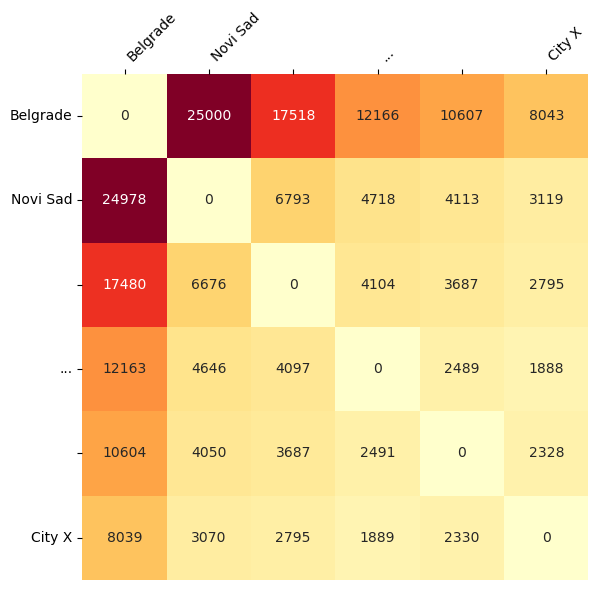

In [21]:
# Create custom location labels - only show A, B, ..., and X
custom_labels = ["Belgrade", "Novi Sad", "", "...", "", "City X"]

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(restructured_matrix, 
            annot=True,  # Show values in cells
            fmt='.0f',   # Format numbers as integers (no scientific notation)
            cmap='YlOrRd',  # Color scheme
            xticklabels=custom_labels,
            yticklabels=custom_labels,
            square=True,  # Make cells square
            cbar=False)  # Remove colorbar

plt.xlabel('')
plt.ylabel('')

# Move x-axis labels to top
plt.gca().xaxis.tick_top()
plt.xticks(rotation=45, ha='left')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [22]:
tot_edge_length = np.sum(graph.es['road_length'])
tot_edge_time = np.sum(graph.es['fft'])

exp_edge_no = graph.ecount()

result_df = []
result_vhl = []
for edge in tqdm(range(exp_edge_no),total=exp_edge_no,desc='percolation'):
    exp_g = graph.copy()
    exp_g.delete_edges(edge)
    
    cur_dis_length = 1 - (np.sum(exp_g.es['road_length'])/tot_edge_length)
    cur_dis_time = 1 - (np.sum(exp_g.es['fft'])/tot_edge_time)
    
    #get new matrix
    perc_matrix = run_shortest_paths(exp_g,grouped_OD,weighting='fft',tqdm_disable=True)
    np.fill_diagonal(perc_matrix, np.nan)
    perc_matrix[perc_matrix == np.inf] = 12    

    # summarize results
    results = SummariseOD(perc_matrix, 12, demand, OD_orig, graph.es[edge]['id'],cur_dis_length,cur_dis_time) 
     
    result_df.append(results)
    
    result_vhl.append([graph.es[edge]['id'],np.nansum(np.multiply(demand,perc_matrix)-np.multiply(demand,OD_orig))])
    
result_df = pd.DataFrame(result_df, columns=['edge_no', 'pct_isolated','pct_unaffected', 'pct_delayed',
                                            'average_time_disruption','distance_disruption','time_disruption',
                                             'unaffected_percentiles','delayed_percentiles','delayed_trips_time'])
#result_df = result_df.replace('--',0)

percolation: 100%|██████████| 5490/5490 [57:18<00:00,  1.60it/s]  


In [23]:
gdf_results = edges.merge(result_df,left_index=True,right_on='edge_no')

In [24]:
vhl_df = pd.DataFrame(result_df[['edge_no','average_time_disruption']],columns=['edge_no','average_time_disruption'])
gdf_vhl = edges.merge(vhl_df,left_index=True,right_on='edge_no')
gdf_vhl['vhl'] = gdf_vhl.average_time_disruption*gdf_vhl.total_aadt

In [25]:
gdf_results['vhl'] = gdf_results.average_time_disruption*gdf_results.total_aadt


In [26]:
gdf_results

,from_id,to_id,objectid,oznaka_deo,smer_gdf1,kategorija,oznaka_put,oznaka_poc,naziv_poce,oznaka_zav,...,pct_isolated,pct_unaffected,pct_delayed,average_time_disruption,distance_disruption,time_disruption,unaffected_percentiles,delayed_percentiles,delayed_trips_time,vhl
0,5,6,3.0,A1005,D,IA,A1,A102,petlja Subotica sever,A103,...,0.0,100.000000,0.000000,NaN,3.958488e-06,3.958488e-06,"[0.971914487748903, 1.6326603332623495, 2.5814...","[nan, nan, nan, nan, nan, nan]",[[[[]]]],NaN
1,8,9,4.0,A1003,D,IA,A1,A101,petlja Horgoš,A102,...,0.0,99.656784,0.343216,0.001360,7.149766e-06,7.149766e-06,"[0.9704395273616573, 1.6301120654155048, 2.576...","[0.0003709577175063927, 0.0015765980378610323,...",[[[[[0.0015766 0.0015766 0.0015766 ... 0.00157...,10.733231
2,9,10,4.0,A1003,D,IA,A1,A101,petlja Horgoš,A102,...,0.0,99.656784,0.343216,0.074892,2.010518e-04,2.010518e-04,"[0.9704395273616573, 1.6301120654155048, 2.576...","[0.0003709577175063927, 0.025098358032239698, ...",[[[[[0.16142125 0.13669385 0.13669385 ... 0.08...,591.045700
3,11,5,4.0,A1003,D,IA,A1,A101,petlja Horgoš,A102,...,0.0,100.000000,0.000000,NaN,6.465483e-06,6.465483e-06,"[0.971914487748903, 1.6326603332623495, 2.5814...","[nan, nan, nan, nan, nan, nan]",[[[[]]]],NaN
4,12,13,5.0,A1023,D,IA,A1,A111,petlja Novi Sad sever,A112,...,0.0,99.908283,0.091717,0.057215,2.300461e-04,2.300461e-04,"[0.971669297300553, 1.6320928840397202, 2.5802...","[0.058710373145842265, 0.05892580978404327, 0....",[[[[[0.05258606 0.05258606 0.05258606 ... 0.04...,683.146321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5425,1951,1952,NaN,None,None,None,None,None,None,None,...,0.0,100.000000,0.000000,NaN,6.658281e-07,6.658281e-07,"[0.971914487748903, 1.6326603332623495, 2.5814...","[nan, nan, nan, nan, nan, nan]",[[[[]]]],NaN
5426,1920,1396,NaN,None,None,None,None,None,None,None,...,0.0,100.000000,0.000000,NaN,1.062951e-06,1.062951e-06,"[0.971914487748903, 1.6326603332623495, 2.5814...","[nan, nan, nan, nan, nan, nan]",[[[[]]]],NaN
5427,1927,1924,NaN,None,None,None,None,None,None,None,...,0.0,100.000000,0.000000,NaN,8.303010e-07,8.303010e-07,"[0.971914487748903, 1.6326603332623495, 2.5814...","[nan, nan, nan, nan, nan, nan]",[[[[]]]],NaN
5428,1944,1945,NaN,None,None,None,None,None,None,None,...,0.0,100.000000,0.000000,NaN,9.531736e-07,9.531736e-07,"[0.971914487748903, 1.6326603332623495, 2.5814...","[nan, nan, nan, nan, nan, nan]",[[[[]]]],NaN


In [27]:
gdf_results[['from_id', 'to_id', 'objectid', 'oznaka_deo', 'smer_gdf1', 'kategorija',
       'oznaka_put', 'oznaka_poc', 'naziv_poce', 'oznaka_zav', 'naziv_zavr',
       'duzina_deo', 'pocetna_st', 'zavrsna_st', 'stanje', 'id',
       'passenger_cars', 'buses', 'light_trucks', 'medium_trucks',
       'heavy_trucks', 'articulated_vehicles', 'total_aadt', 'oznaka_deo_left',
       'index_right', 'oznaka_deo_right', 'road_length', 'speed', 'fft',
       'geometry', 'edge_no', 'pct_isolated', 'pct_unaffected', 'pct_delayed',
       'average_time_disruption', 'distance_disruption', 'time_disruption','vhl']].to_parquet(intermediate_path / "criticality_results.parquet")

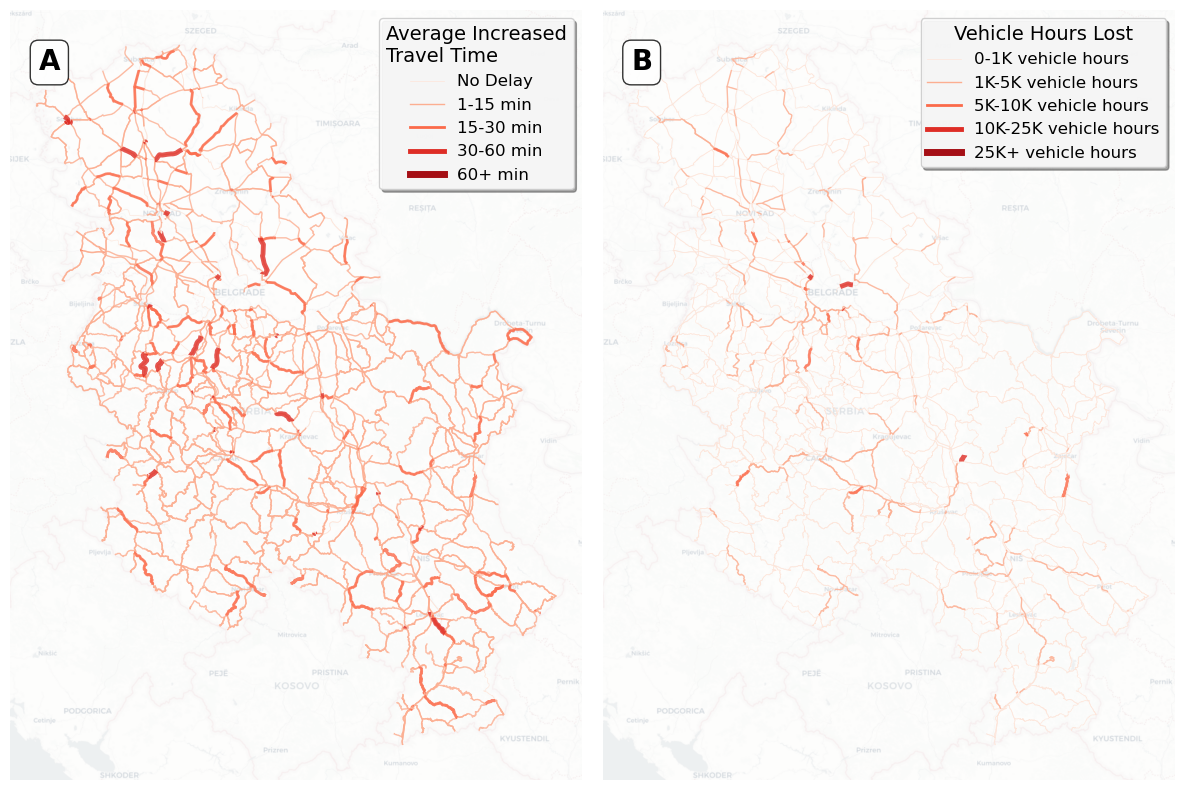

In [28]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), facecolor='white')
colors = ['#fee5d9', '#fcae91', '#fb6a4a', '#de2d26', '#a50f15']

# ============ LEFT MAP (A) - Average Time Delay ============
bins1 = [0, 0.01, 0.25, 0.5, 1, np.inf]
labels1 = ['No Delay', '1-15 min', '15-30 min', '30-60 min', '60+ min']
gdf_results['disruption_class'] = pd.cut(
    gdf_results['average_time_disruption'], 
    bins=bins1, labels=labels1, include_lowest=True
)

linewidth_map1 = {
    'No Delay': 0.5, '1-15 min': 1.0, '15-30 min': 2.0, 
    '30-60 min': 3.5, '60+ min': 5.0
}

for i, (class_name, width) in enumerate(linewidth_map1.items()):
    subset = gdf_results[gdf_results['disruption_class'] == class_name]
    if not subset.empty:
        subset.to_crs(3857).plot(ax=ax1, color=colors[i], linewidth=width, alpha=0.8)

cx.add_basemap(ax=ax1, source=cx.providers.CartoDB.Positron, alpha=0.4, attribution=False)
ax1.set_aspect('equal')
ax1.axis('off')

legend_elements1 = [Line2D([0], [0], color=colors[i], lw=width, label=class_name)
                    for i, (class_name, width) in enumerate(linewidth_map1.items())]
ax1.legend(handles=legend_elements1, title='Average Increased\nTravel Time', loc='upper right',
           fontsize=12, title_fontsize=14, frameon=True, fancybox=True, shadow=True,
           framealpha=0.9, facecolor='white', edgecolor='#cccccc')

ax1.text(0.05, 0.95, 'A', transform=ax1.transAxes, fontsize=20, fontweight='bold',
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

# ============ RIGHT MAP (B) - Vehicle Hours Lost ============
bins2 = [0, 1000, 5000, 10000, 25000, np.inf]
labels2 = ['0-1K', '1K-5K', '5K-10K', '10K-25K', '25K+']
gdf_vhl['vhl_class'] = pd.cut(
    gdf_vhl['vhl'], 
    bins=bins2, labels=labels2, include_lowest=True
)

linewidth_map2 = {
    '0-1K': 0.5, '1K-5K': 1.0, '5K-10K': 2.0, 
    '10K-25K': 3.5, '25K+': 5.0
}

for i, (class_name, width) in enumerate(linewidth_map2.items()):
    subset = gdf_vhl[gdf_vhl['vhl_class'] == class_name]
    if not subset.empty:
        subset.to_crs(3857).plot(ax=ax2, color=colors[i], linewidth=width, alpha=0.8)

cx.add_basemap(ax=ax2, source=cx.providers.CartoDB.Positron, alpha=0.4, attribution=False)
ax2.set_aspect('equal')
ax2.axis('off')

legend_elements2 = [Line2D([0], [0], color=colors[i], lw=width, label=f'{class_name} vehicle hours')
                    for i, (class_name, width) in enumerate(linewidth_map2.items())]
ax2.legend(handles=legend_elements2, title='Vehicle Hours Lost', loc='upper right',
           fontsize=12, title_fontsize=14, frameon=True, fancybox=True, shadow=True,
           framealpha=0.9, facecolor='white', edgecolor='#cccccc')

ax2.text(0.05, 0.95, 'B', transform=ax2.transAxes, fontsize=20, fontweight='bold',
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

# Final adjustments
plt.tight_layout()
plt.savefig(Path("figures") / 'SPOF_results.png', dpi=300, bbox_inches='tight')
plt.show()